In [3]:
import sys
sys.path.append("../")

from rbm import fasta_read, get_beta_and_W, all_weights, RBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import subprocess as sp
import matplotlib.image as mpimg

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [4]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/cov_trained_rbms/"
rounds = [f"r{i}" for i in range(1, 13)]
rounds_w = [f"r{i}_w" for i in range(1, 13)]

#### Generate Weights

In [ ]:
# Did not train rounds 1 or 2. 2 crashed and 1 takes too much memory

# generate weights in respective
for rid, round in enumerate(rounds[2:]):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = RBM.load_from_checkpoint(checkp)
    all_weights(tmp, version_dir +round+"_weights", 5, 1, 6, 2, "dna")

In [6]:
def assign(x):
    if x < 10:
        return "L" # low
    elif x < 50:
        return "M" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(rounds, dir="../../cov", assignment_function=assign, threads=12)

Process Time 11.354294061660767
Process Time 5.811099290847778
Process Time 0.38408613204956055
Process Time 0.32775425910949707
Process Time 1.42136812210083
Process Time 0.91446852684021
Process Time 1.7486732006072998
Process Time 0.5666377544403076
Process Time 0.15098142623901367
Process Time 0.4097137451171875
Process Time 0.22255611419677734
Process Time 0.4452803134918213


In [5]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in rounds:
    paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/"))

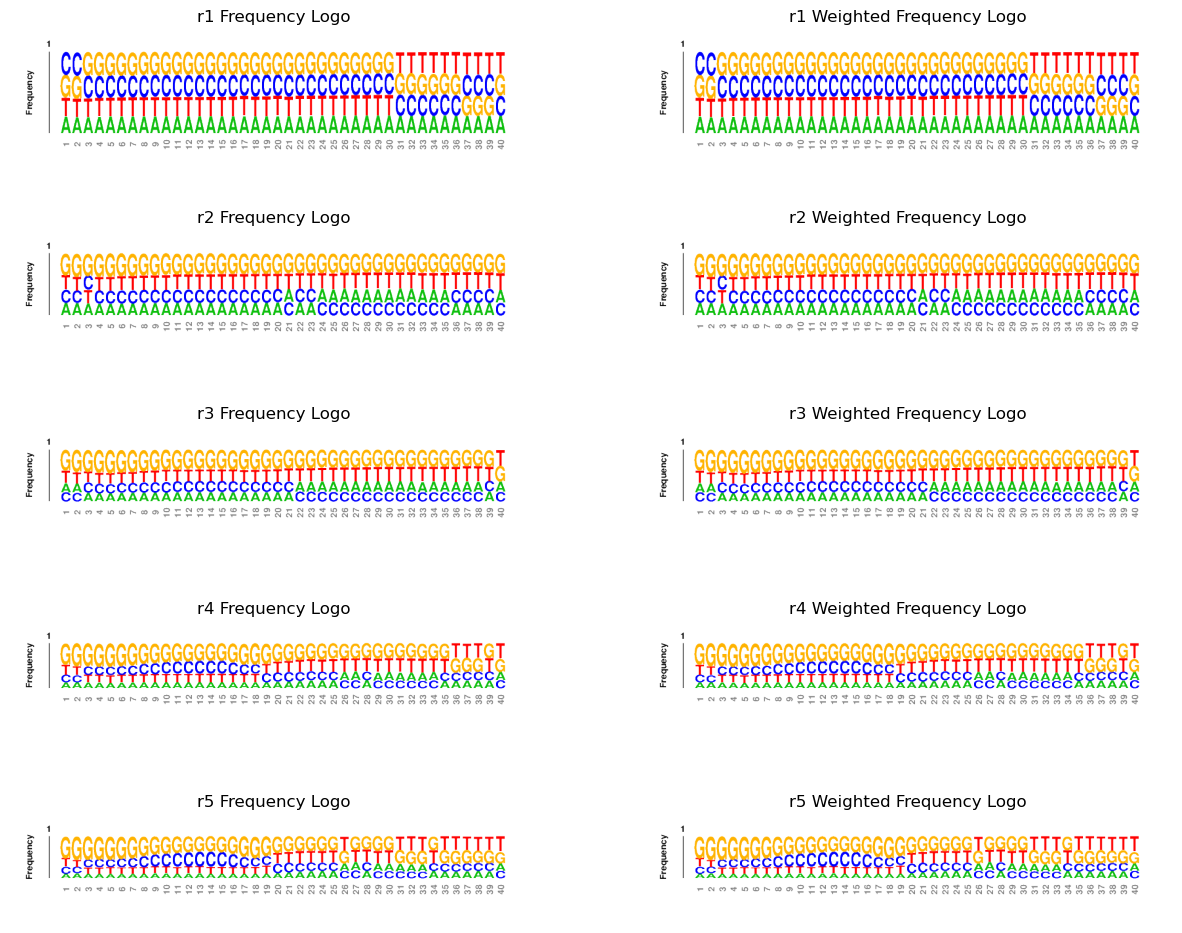

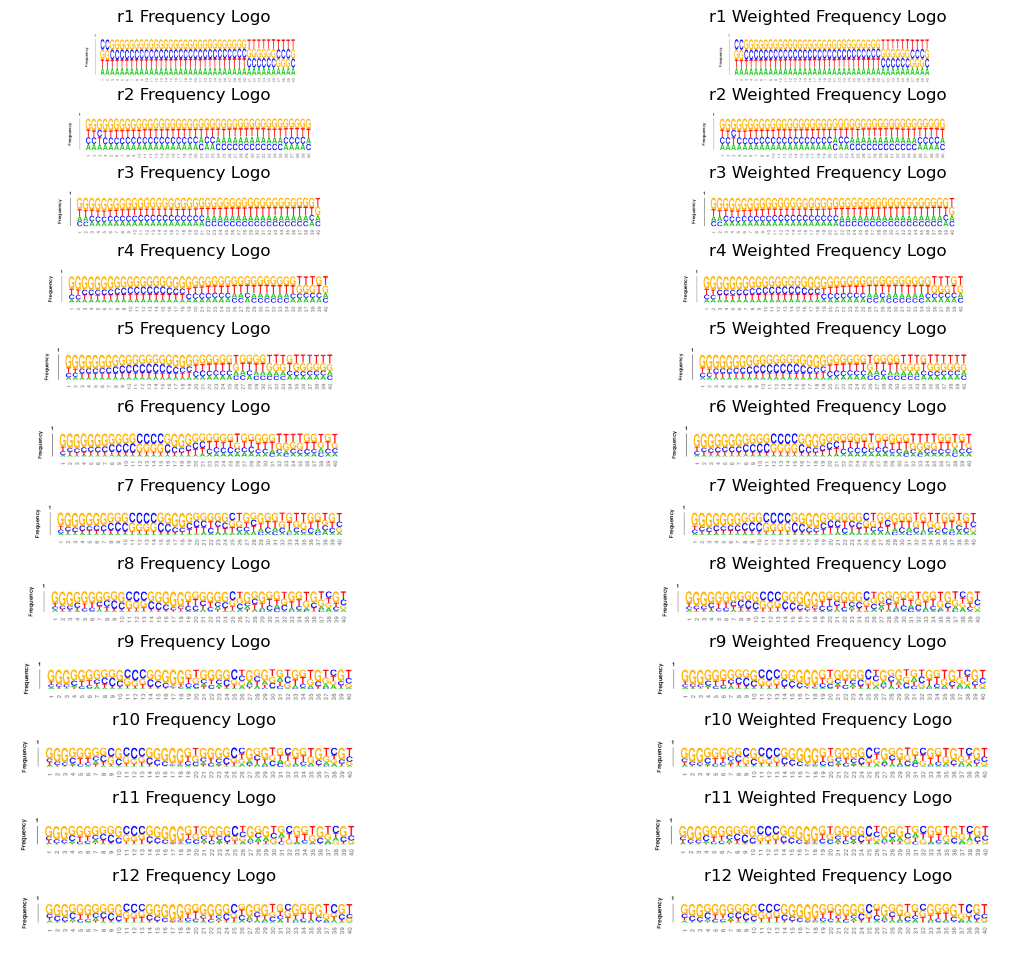

In [7]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

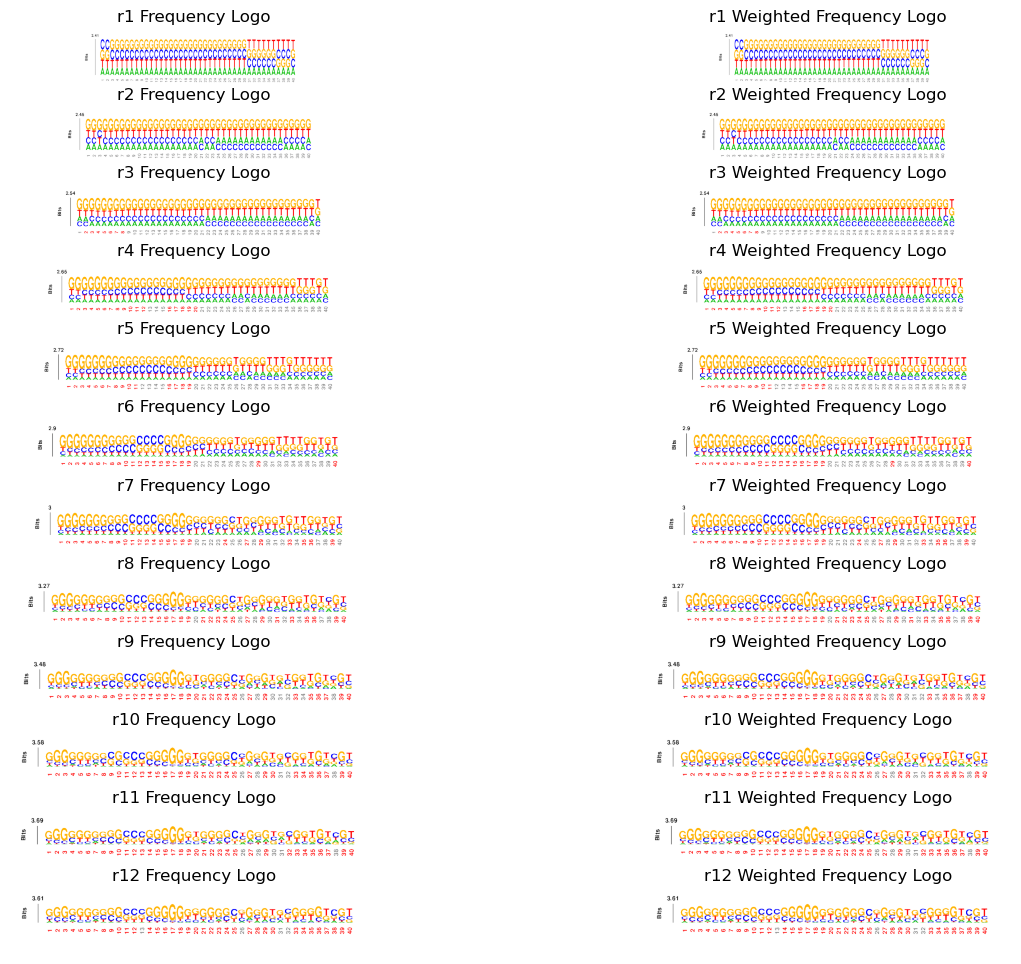

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [ ]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    sns.histplot(data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

count_dist(all_data, "Unique Sequence Count Distribution")

In [11]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r11_w", rbmdir=mdir)
r11_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(rounds_w[2::2], r11_rbm, all_data, "r11_w_v0")

In [12]:
r11_likelihoods = am.get_likelihoods("./generated/r11_w_v0.json")

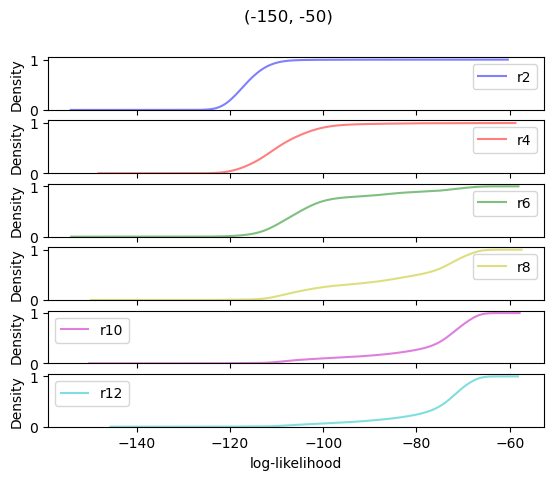

In [6]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r11_likelihoods["likelihoods"], rounds_w[2::2], rounds_w[2::2], xlim=(-150, -50), cdf=True)

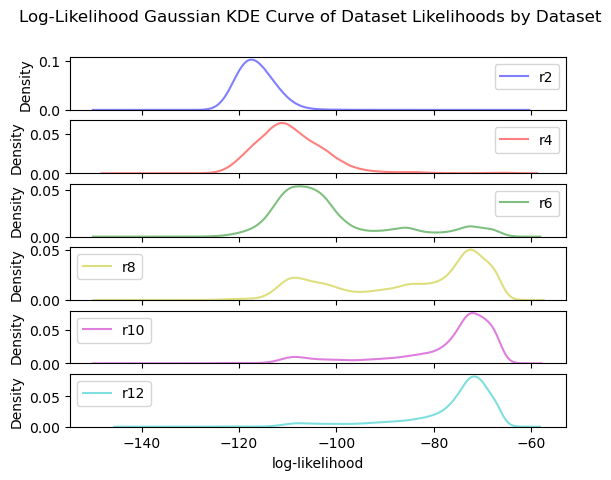

In [8]:
am.plot_likelihoods(r11_likelihoods["likelihoods"], rounds_w[2::2], rounds_w[2::2], xlim=(-150, -50), cdf=False)

In [20]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])



# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



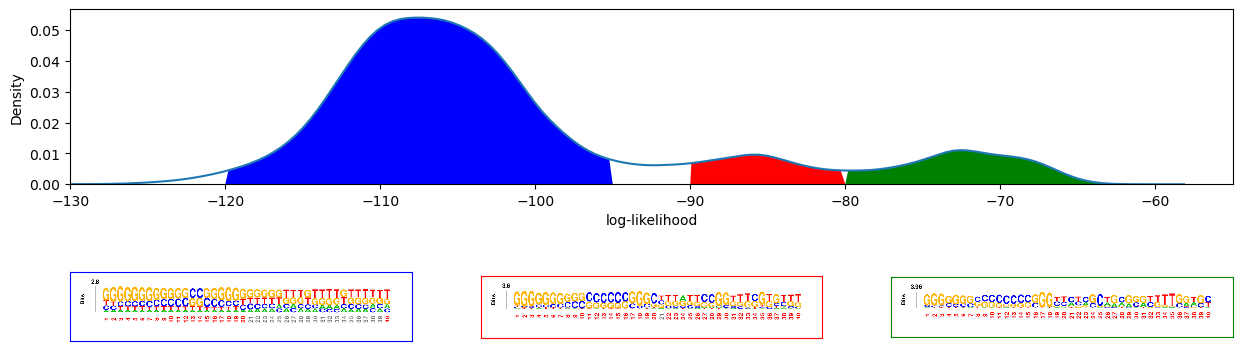

In [21]:
multi_peak_seq_log_fig(all_data, r11_likelihoods["likelihoods"], "r5_w", [[-120, -95], [-90, -80], [-80, 0]], weight=False, xlim=(-130, -55))

In [5]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r3_w", rbmdir=mdir)
r3_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(rounds[2::2], r3_rbm, all_data, "r3_v0_w_odd_rounds")

In [6]:
r3_likelihoods = am.get_likelihoods("./generated/r3_v0_w_odd_rounds.json")

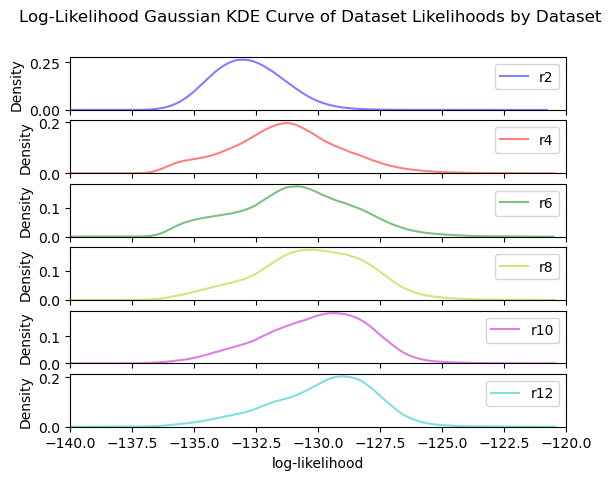

In [13]:
# assign likelihoods in new pd dataframe
am.plot_likelihoods(r3_likelihoods["likelihoods"], rounds[2::2], rounds[2::2], xlim=(-140, -120))

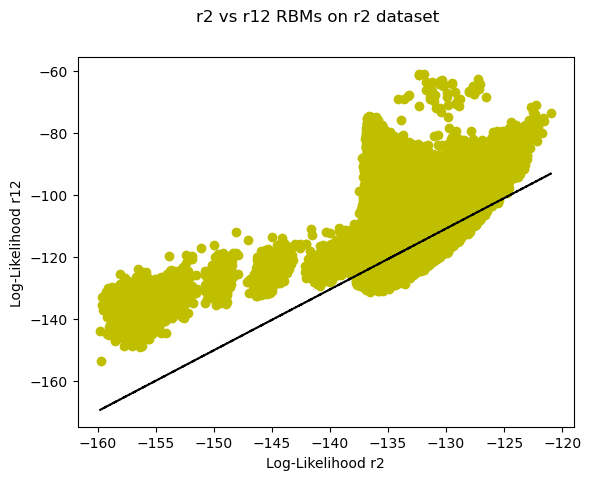

In [16]:
am.compare_likelihood_correlation(r3_likelihoods["likelihoods"]["r3_w"], r11_likelihoods["likelihoods"]["r3_w"], "r3 vs r11 RBMs on r3 dataset", ["r3_2w", "r11_2"])

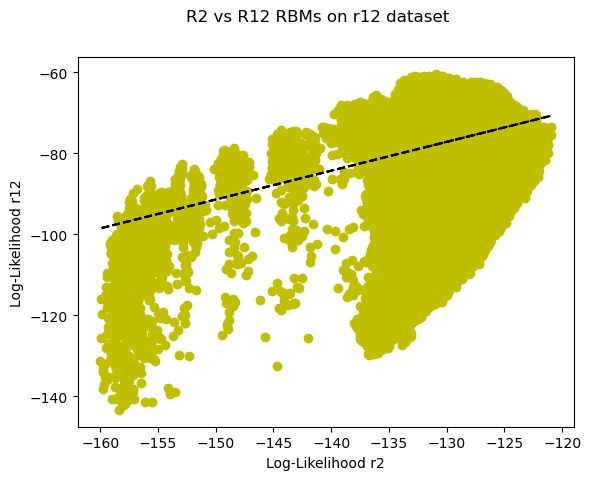

In [18]:
am.compare_likelihood_correlation(r3_likelihoods["likelihoods"]["r11_w"], r11_likelihoods["likelihoods"]["r11_w"], "R3 vs R11 RBMs on r11 dataset", ["r3_w", "r11_w"])

In [15]:
exp_seqs = {
    "SP5":  'TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT',
    "SP6":  "CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT",
    "SP7":  "CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG",
    "SP6C": 'CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT',
    "SP634": "---CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG---",
    "SP634G": "---CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG---",
    "SP634C": "---CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG---",
    "SP634A": "---CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG---",
    "SP630": "-----CATGGTAGGTATTGCATGGTAGGGATAGTG-----",
    "SP619": "--------------TATTGCATGGTAGGGATAG-------",
}

exp_A_seqs = {
    "SP5":  'TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT',
    "SP6":  "CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT",
    "SP7":  "CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG",
    "SP6C": 'CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT',
    "SP634": "AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA",
    "SP634G": "AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA",
    "SP634C": "AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA",
    "SP634A": "AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA",
    "SP630": "AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA",
    "SP619": "AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA",
}



exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_pd = pd.DataFrame(exp_set)
exp_A_pd = pd.DataFrame(exp_A_set)

In [16]:
exp_3_seqs, exp_3_likelis = r3_rbm.predict(exp_pd)
exp_3_A_seqs, exp_3_A_likelis = r3_rbm.predict(exp_A_pd)
exp_11_seqs, exp_11_likelis = r11_rbm.predict(exp_pd)
exp_11_A_seqs, exp_11_A_likelis = r11_rbm.predict(exp_A_pd)

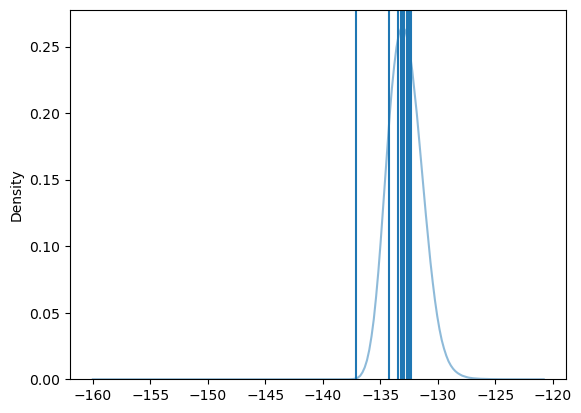

In [17]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r3_likelihoods["likelihoods"]["r3_w"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_3_A_likelis:
    plt.axvline(likeli)
plt.show()

In [18]:
for i in range(len(exp_seqs)):
    print(exp_3_A_seqs[i], exp_3_A_likelis[i])

TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.68197807155985
CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.51246189410242
CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG -132.31719745223856
CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT -132.93433717970836
AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA -133.00513372045458
AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA -132.61341545160053
AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA -133.42270537788107
AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA -133.18874658196373
AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA -134.20747154167958
AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA -137.0695806022038


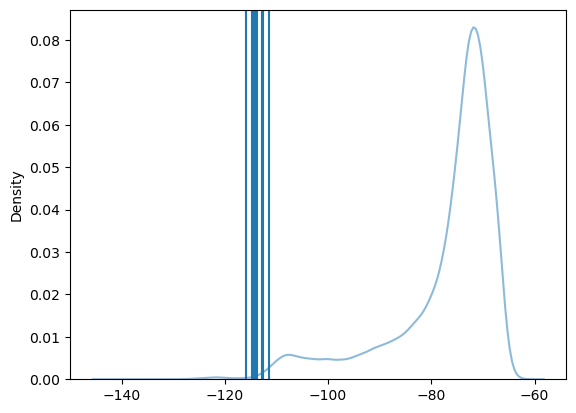

In [19]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r11_likelihoods["likelihoods"]["r11_w"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_11_A_likelis:
    plt.axvline(likeli)
plt.show()

In [21]:
for i in range(len(exp_seqs)):
    print(exp_11_A_seqs[i], exp_11_A_likelis[i])

TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -112.75526198721789
CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -114.15914836314298
CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG -115.97698502317093
CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT -114.71492920002842
AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA -113.85388701234373
AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA -112.85139824681642
AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA -114.32640912354373
AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA -114.27279548960632
AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA -112.59060938791754
AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA -111.37298336781086


In [22]:
r11_likelihoods.keys()

dict_keys(['likelihoods', 'sequences'])

In [24]:
lik = r11_likelihoods["likelihoods"]["r11_w"]
seq = r11_likelihoods["sequences"]["r11_w"]

for lid, l in enumerate(lik):
    if l > -62:
        print(seq[lid])

GGGGGGCGCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGCGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGCCCCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGCGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCCGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCCGCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCGCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGGGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCGGCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGCCGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGCGCGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGCCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGGGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC
GCGCCCCCCCCCCCCC